## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import seaborn as sns 
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.layers import Flatten 
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample 
from keras.utils import np_utils
import warnings 
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
6011,00001620_002.png,No Finding,2,1620,42,M,PA,2992,2991,0.143,0.143,NaN,/data/images_002/images/00001620_002.png
87483,00021610_030.png,Effusion|Mass,30,21610,45,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00021610_030.png
96295,00025342_001.png,No Finding,1,25342,60,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00025342_001.png


###### Dataset cleaning

In [3]:
# copy data
data=all_xray_df.copy()

In [4]:
# Sample to see what's look the dataset
data.sample()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
85623,00021117_000.png,No Finding,0,21117,66,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00021117_000.png


###### Dealing with  OriginalImage[Width Height] and  OriginalImagePixelSpacing[x y] columns

In [5]:
# OriginalImage[Width Height], OriginalImagePixelSpacing[x y]

In [6]:
data.head(2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png


In [7]:
# Test slicing 
data.iloc[1:2:,7] # This is correspond of Height of OriginalImage[Width Height]

1    2894
Name: OriginalImage[Width, dtype: int64

In [8]:
# Slicing of OriginalImage[Width Height]
OriginalImageWidth=data.iloc[:,7]
OriginalImageHeight=data.iloc[:,8]
print(OriginalImageWidth[0])
print(OriginalImageHeight[0])

2682
2749


In [9]:
# Slicing of OriginalImagePixelSpacing[x y]
OriginalImagePixelSpacing_x=data.iloc[:,9]
OriginalImagePixelSpacing_y=data.iloc[:,10]
print(OriginalImagePixelSpacing_x[0])
print(OriginalImagePixelSpacing_y[0])

0.14300000000000002
0.14300000000000002


In [10]:
data.shape

(112120, 13)

In [11]:
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [12]:
data = data.iloc[:,0:7]
data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA
...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA
112116,00030802_000.png,No Finding,0,30802,29,M,PA
112117,00030803_000.png,No Finding,0,30803,42,F,PA
112118,00030804_000.png,No Finding,0,30804,30,F,PA


In [13]:
data['OriginalImageWidth']=list(OriginalImageWidth)
data['OriginalImageHeight']=list(OriginalImageHeight)
data['OriginalImagePixelSpacing_x']=list(OriginalImagePixelSpacing_x)
data['OriginalImagePixelSpacing_y']=list(OriginalImagePixelSpacing_y)
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [14]:
# Let's add path and Image Index 
data['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/data/images_001/images/00000003_000.png


In [15]:
data.shape

(112120, 12)

In [16]:
# Columns names
data.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path'],
      dtype='object')

In [17]:
# Let's get rid the space within the columns name 
data.columns = data.columns.str.replace(' ', '_')
data.columns

Index(['Image_Index', 'Finding_Labels', 'Follow-up_#', 'Patient_ID',
       'Patient_Age', 'Patient_Gender', 'View_Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path'],
      dtype='object')

In [18]:
data.head()

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/data/images_001/images/00000003_000.png


In [19]:
data.shape

(112120, 12)

In [20]:
#Finding_Labels
data.Finding_Labels.unique()

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass',
       'Emphysema|Pneumothorax', 'Pleural_Thickening',
       'Effusion|Emphysema|Infiltration|Pneumothorax',
       'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Effusion|Pneumonia|Pneumothorax', 'Pneumothorax',
       'Effusion|Infiltration|Pneumothorax', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
       'Emphysema|Mass', 'Emphysema|Mass|Pneumothorax',
       'Atelectasis|Pneumothorax', 'Cardiomegaly|Emphysema|Pneumothorax',
       'Mass|Pleural_Thickening', 'Cardiomegaly|Mass|Pleural_Thickening',
       'Effusion|Infiltra

In [21]:
labels = np.unique(list(chain(*data['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [22]:
data.shape

(112120, 12)

In [23]:
for label in labels:
    if len(label)>1: # leave out empty labels
        data[label] = data['Finding_Labels'].map(lambda finding: 1 if label in finding else 0)

In [24]:
data.shape

(112120, 27)

In [25]:
data.head()

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [26]:
data.columns

Index(['Image_Index', 'Finding_Labels', 'Follow-up_#', 'Patient_ID',
       'Patient_Age', 'Patient_Gender', 'View_Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [27]:
# Let's get rid Finding_Labels 
del data['Finding_Labels']

In [28]:
# Let's replace ' ' by '_' within new columns 
data.columns = data.columns.str.replace(' ', '_')

In [29]:
# Cleaned DataSet.
data.head()

,Image_Index,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,0,0,1,0,0,0,0,0,0,0


In [30]:
data.columns

Index(['Image_Index', 'Follow-up_#', 'Patient_ID', 'Patient_Age',
       'Patient_Gender', 'View_Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [31]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column


In [32]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
pneumonia_class_1 = filter(None, data['Pneumonia'] == 1)
pneumonia_class_0 = filter(None, data['Pneumonia'] ==0)
print('Pneumonia cases:', len(list(pneumonia_class_1)))
print('Pneumonia no cases:', len(list(pneumonia_class_0)))

Pneumonia cases: 1431
Pneumonia no cases: 110689


0    110689
1      1431
Name: Pneumonia, dtype: int64


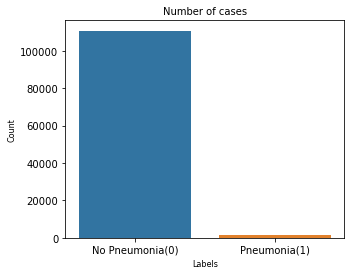

In [33]:
# Get the counts for each class
cases_count = data['Pneumonia'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=10)
plt.xlabel('Labels', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['No Pneumonia(0)', 'Pneumonia(1)'])
plt.show()

This is clearly imbalance dataset, we will have take it in account in order to have balanced dataset

## Create your training and testing data:

In [34]:
def create_splits(df, test_size,var_dependente):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_data, val_data=train_test_split(df, test_size=test_size, stratify=df[var_dependente])
    return train_data, val_data

In [35]:
train_data, val_data=create_splits(data, 0.2, 'Pneumonia')
print(train_data.shape)
print(val_data.shape)

(89696, 26)
(22424, 26)


In [36]:
# Check the distribution of pneumonia cases in the test and validation set
print("Train set", train_data['Pneumonia'].sum()/len(train_data))
print("validation set", val_data['Pneumonia'].sum()/len(val_data))

Train set 0.012765340706386016
validation set 0.012754191937210132


###### Handling unbalancing classes

In [37]:
# Get a balanced dataset (50/50) = equal amount of positive and negative cases in Training
p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]
print("Train set :   ", train_data['Pneumonia'].sum()/len(train_data))


# Get a validation set with at 20% Pneumonia cases
p_inds = val_data[val_data.Pneumonia==1].index.tolist()
np_inds = val_data[val_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_data = val_data.loc[p_inds + np_sample]
print("validation set :  ", val_data['Pneumonia'].sum()/len(val_data))

Train set :    0.5
validation set :   0.2


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [38]:
# define globals
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [39]:
# Data Augmentation Function 

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    idg = ImageDataGenerator(rescale = 1 / 255.0,
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.1, 
                             width_shift_range = 0.1, 
                             rotation_range = 25, 
                             shear_range = 0.1,
                             zoom_range = 0.15)
    
    return idg

In [40]:
def make_train_gen(idg, data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = idg.flow_from_dataframe(dataframe=data, 
                                          directory=None, 
                                          x_col ='path',
                                          y_col ='Pneumonia',
                                          class_mode = 'raw',
                                          target_size = IMG_SIZE, 
                                          batch_size = BATCH_SIZE)
        
    return train_gen

In [41]:
def make_val_gen(val_dat):
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia',
                                              class_mode = 'raw',
                                              target_size = IMG_SIZE, 
                                              batch_size = BATCH_SIZE) 
    
    return val_gen

In [42]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames.


Found 2290 validated image filenames.


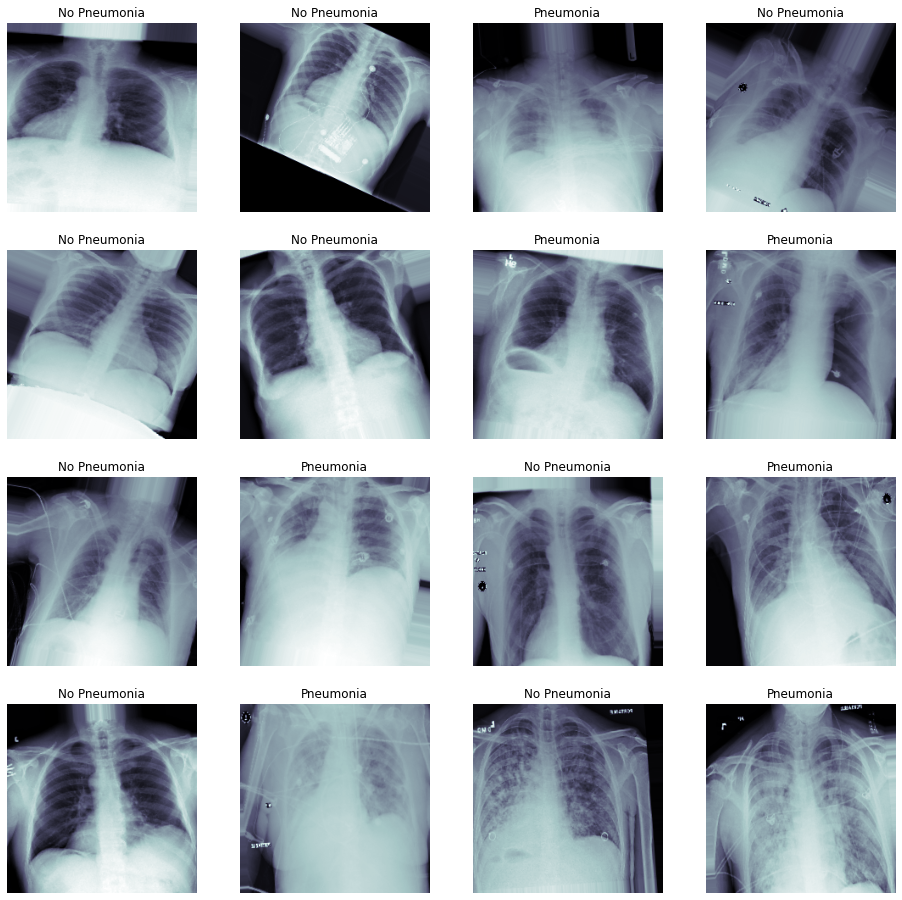

In [43]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
imageDataGenerator = my_image_augmentation()
train_gen = make_train_gen(imageDataGenerator, train_data)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [44]:
def load_pretrained_model(layer='block5_pool'):
    model=VGG16(include_top=True, weights='imagenet')
    transfer_layer=model.get_layer(layer)
    vgg_model=Model(input=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable=False
    return vgg_model
    

In [45]:
def build_my_model():
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model.add(load_pretrained_model())
    
    # Addition layers 
    my_model.add(Flatten())
    my_model.add(Dropout(0.5)) # 50% to handle overfitting
    
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [46]:
model=build_my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [47]:
## Set optimizer, loss function, and learning rate
epochs = 30
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)
loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [48]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'auto', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'auto', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [49]:
## train your model

# Todo

history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = epochs , 
                          verbose=1,
                          callbacks = callbacks_list)

Epoch 1/30
36/36 [==============================] - 62s 2s/step - loss: 0.7509 - accuracy: 0.5148 - val_loss: 0.7060 - val_accuracy: 0.4531

Epoch 00001: val_loss improved from inf to 0.70596, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
36/36 [==============================] - 58s 2s/step - loss: 0.7116 - accuracy: 0.5397 - val_loss: 0.7107 - val_accuracy: 0.5312

Epoch 00002: val_loss did not improve from 0.70596
Epoch 3/30
36/36 [==============================] - 58s 2s/step - loss: 0.6930 - accuracy: 0.5559 - val_loss: 0.6473 - val_accuracy: 0.6250

Epoch 00003: val_loss improved from 0.70596 to 0.64730, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
36/36 [==============================] - 58s 2s/step - loss: 0.6848 - accuracy: 0.5725 - val_loss: 0.7307 - val_accuracy: 0.5156

Epoch 00004: val_loss did not improve from 0.64730
Epoch 5/30
36/36 [==============================] - 57s 2s/step - loss: 0.6718 - accuracy: 0.5878 - val_loss: 0.5582 - val_accuracy: 0

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [57]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
val_y = val_data['Pneumonia']
y_pred = model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [58]:
val_y

15552    1
54755    1
96433    1
7079     1
97119    1
        ..
96481    0
85085    0
42767    0
54306    0
86031    0
Name: Pneumonia, Length: 1430, dtype: int64

In [71]:
# function to plot the roc_curve
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', aps))
    #c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    

# function to plot the history
def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)
    
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("Model Loss")
    
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    plt.show()
    

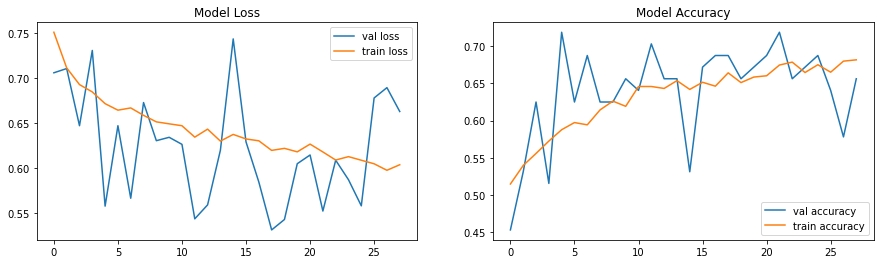

In [72]:
hist=plot_history(history)

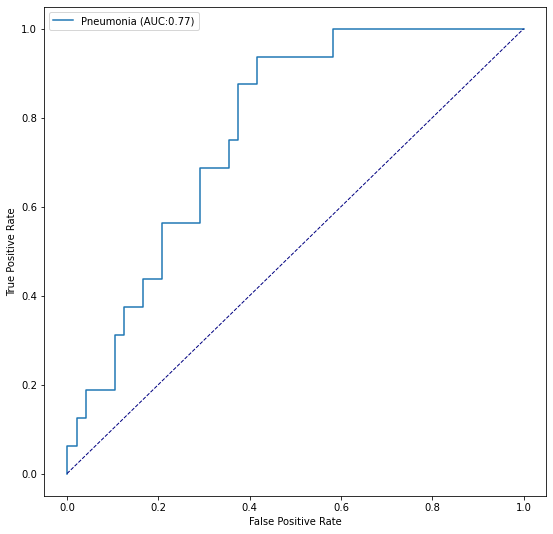

In [73]:
plot_auc(valY, y_pred)

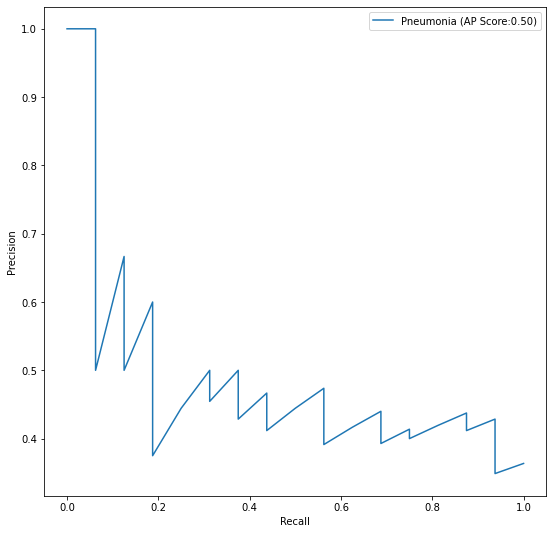

In [74]:
plot_precision_recall_curve(valY, y_pred)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [77]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


precision, recall, thresholds = precision_recall_curve(valY, y_pred)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]


# Look at the threshold where precision is 0.8
#precision_value = 0.8
#idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.42857142857142855
Recall is: 0.9375
Threshold is: 0.35657388
F1 Score is: 0.588235294117647


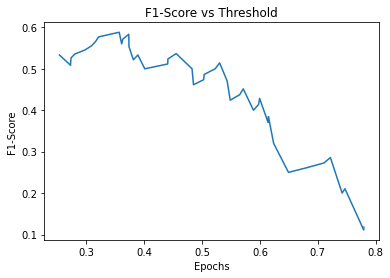

In [78]:
plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

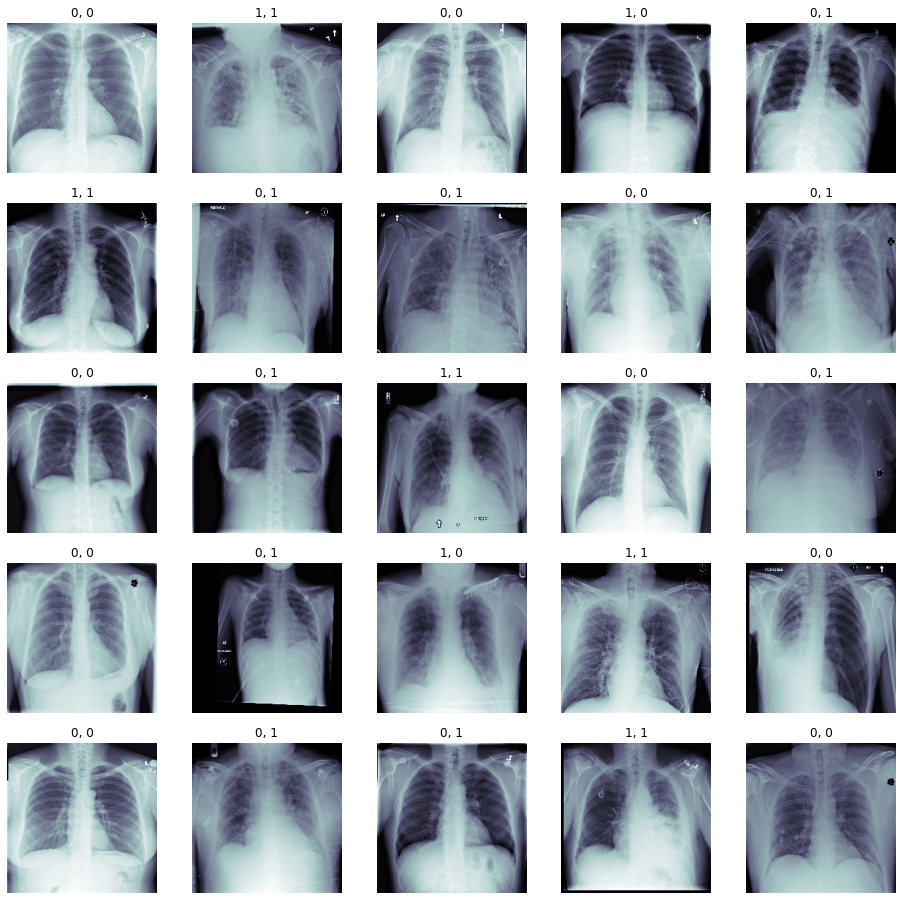

In [79]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [81]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)